In [97]:
import ee
import geopandas as gpd
import fiona
import shapely
import contextily as cx
import json
from src.visualization import ee_viz
from src.data import mtbs
from src.data import land_cover
from src.data import shape_processor
import src.data.ee_utils as ee_utils
import numpy as np
from src.data import terrain

import importlib
importlib.reload(ee_viz)
importlib.reload(ee_utils)
importlib.reload(mtbs)
importlib.reload(terrain)

2023-05-27 21:43:53,946 DEBUG: Logger /home/jk871/fire-regen/src/data/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.terrain' from '/home/jk871/fire-regen/src/data/terrain.py'>

In [3]:
ee.Authenticate()


Successfully saved authorization token.


In [69]:
ee.Initialize()

### Get Regions of interest

In [64]:
# Fetch simplified regions of interest - to avoid processing problems with really complicated shapes.
seki = gpd.read_file("../../data/shapefiles/seki_convex_hull.shp")
sierras = gpd.read_file("../../data/shapefiles/sierras_convex_hull.shp")

In [65]:
seki_complex = gpd.read_file("../../data/shapefiles/seki.shp")
seki_box = shape_processor.get_box(seki_complex)

In [66]:
sierras_complex = gpd.read_file("../../data/shapefiles/sierras.shp")
sierras_box = shape_processor.get_box(sierras_complex)

In [ ]:
seki.to_crs(3857).explore()

In [44]:
sierras.to_crs(3857).explore()

### Get Burn Severity Data

In [12]:
burn_severity_ic = mtbs.get_burn_severity_data().sort('system:time_start', False).filterDate('2020', '2021')

In [13]:
burn_severity_ic

In [14]:
ee_viz.viz_burn_severity(burn_severity_ic.first(), sierras.geometry.iloc[0], ['burn_severity', 'burn_year'])

{'max': {'burn_severity': 6, 'burn_year': 2020}, 'mean': {'burn_severity': 2.5847411171975057, 'burn_year': 2020}, 'min': {'burn_severity': 1, 'burn_year': 2020}, 'std': {'burn_severity': 0.9584508443717643, 'burn_year': 0}, 'sum': {'burn_severity': 14269359.91372549, 'burn_year': 11151641777.176472}}


{'max': {'burn_severity': 6, 'burn_year': 2020}, 'mean': {'burn_severity': 2.5847411171975057, 'burn_year': 2020}, 'min': {'burn_severity': 1, 'burn_year': 2020}, 'std': {'burn_severity': 0.9584508443717643, 'burn_year': 0}, 'sum': {'burn_severity': 14269359.91372549, 'burn_year': 11151641777.176472}}


Map(center=[38.81702351908157, -119.91791513913883], controls=(WidgetControl(options=['position', 'transparent…

### Get aggregated burn data - last burn severity for each pixel, and burn count for each pixel

In [6]:
burn_data = mtbs.get_aggregated_burn_data()
burn_data

In [ ]:
ee_viz.viz_burn_severity(burn_data, seki.geometry.iloc[0], ['last_burn_severity', 'last_burn_year', 'burn_count'])

In [8]:
ee_viz.viz_burn_severity(burn_data, sierras_box.geometry.iloc[0], ['last_burn_severity', 'last_burn_year', 'burn_count'])

Map(center=[38.529900913720695, -119.99158443785402], controls=(WidgetControl(options=['position', 'transparen…

### Save Fire Raster as Geo Tiff

In [ ]:
ee_utils.save_image_to_drive(burn_data, polygon=seki_box.geometry[0], img_name='burn_data', scale=30)

In [ ]:
ee_utils.save_image_to_drive(burn_data, polygon=sierras_box.geometry[0], img_name='burn_data_sierras', scale=30)

### Get Landsat data

In [70]:
from src.data.ee import landsat_import
importlib.reload(landsat_import)
importlib.reload(ee_utils)

2023-05-27 16:04:54,257 DEBUG: Logger /home/jk871/fire-regen/src/data/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.ee_utils' from '/home/jk871/fire-regen/src/data/ee_utils.py'>

In [71]:
ls8_2018 = landsat_import.get_landsat(sierras.geometry[0], '2019-01-01')
ls8_2019 = landsat_import.get_landsat(sierras.geometry[0], '2020-01-01')
ls8_2020 = landsat_import.get_landsat(sierras.geometry[0], '2021-01-01')
ls8_2021 = landsat_import.get_landsat(sierras.geometry[0], '2022-01-01')
ls8_2022 = landsat_import.get_landsat(sierras.geometry[0], '2023-01-01')

In [32]:
ls8.bandNames().getInfo()

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'nbr', 'ndvi']

In [ ]:
bands = ['SR']

In [72]:
ee_utils.save_image_to_drive_per_band(ls8_2018, polygon=sierras_box.geometry[0], img_name="landsat_2018", scale=30)

In [41]:
ee_utils.save_image_to_drive_per_band(ls8_2019, polygon=sierras_box.geometry[0], img_name="landsat_2019", scale=30)

In [42]:
ee_utils.save_image_to_drive_per_band(ls8_2020, polygon=sierras_box.geometry[0], img_name="landsat_2020", scale=30)

In [43]:
ee_utils.save_image_to_drive_per_band(ls8_2021, polygon=sierras_box.geometry[0], img_name="landsat_2021", scale=30)

In [44]:
ee_utils.save_image_to_drive_per_band(ls8_2022, polygon=sierras_box.geometry[0], img_name="landsat_2022", scale=30)

### Get Land Cover Raster from Dynamic World

In [45]:
dw_2018 = land_cover.get_land_cover('2018-01-01', '2019-01-01', sierras.geometry[0])
dw_2019 = land_cover.get_land_cover('2019-01-01', '2020-01-01', sierras.geometry[0])
dw_2020 = land_cover.get_land_cover('2020-01-01', '2021-01-01', sierras.geometry[0])
dw_2021 = land_cover.get_land_cover('2021-01-01', '2022-01-01', sierras.geometry[0])
dw_2022 = land_cover.get_land_cover('2022-01-01', '2023-01-01', sierras.geometry[0])

In [46]:
ee_utils.save_image_to_drive(dw_2018, polygon=sierras_box.geometry[0], img_name='dynamic_world_2018', scale=30)
ee_utils.save_image_to_drive(dw_2019, polygon=sierras_box.geometry[0], img_name='dynamic_world_2019', scale=30)
ee_utils.save_image_to_drive(dw_2020, polygon=sierras_box.geometry[0], img_name='dynamic_world_2020', scale=30)
ee_utils.save_image_to_drive(dw_2021, polygon=sierras_box.geometry[0], img_name='dynamic_world_2021', scale=30)
ee_utils.save_image_to_drive(dw_2022, polygon=sierras_box.geometry[0], img_name='dynamic_world_2022', scale=30)

### Get Terrain Data

In [98]:
terrain_img = terrain.get_terrain_image(sierras.geometry[0], 30)
terrain_img

Name,Description
elevation,Elevation


In [99]:
ee_utils.save_image_to_drive_per_band(terrain_img, polygon=sierras_box.geometry[0], img_name="terrain", scale=30)

### Merge tif files

All the Rasters are downloaded from Earth Engine as tif files. We need to do two things:
1. For any rasters that have been downloaded as multiple files - merge them into a single raster.
2. Merge all rasters that represent single bands, into a single raster with multiple bands.

In [105]:
from src.data.rasters import landsat_loader
importlib.reload(landsat_loader)

2023-05-27 23:00:55,401 DEBUG: Logger /home/jk871/fire-regen/src/data/rasters/landsat_loader.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.rasters.landsat_loader' from '/home/jk871/fire-regen/src/data/rasters/landsat_loader.py'>

In [100]:
landsat_loader.process_landsat_rasters(2020, 2021)

2023-05-27 22:02:34,340 DEBUG: Processing LANDSAT rasters for year 2020 [in process_landsat_rasters at /home/jk871/fire-regen/src/data/rasters/landsat_loader.py:69]
nbr
landsat_2020_nbr
ndvi
landsat_2020_ndvi
SR_B1
landsat_2020_SR_B1
SR_B2
landsat_2020_SR_B2
SR_B3
landsat_2020_SR_B3
SR_B4
landsat_2020_SR_B4
SR_B5
landsat_2020_SR_B5
SR_B6
landsat_2020_SR_B6
SR_B7
landsat_2020_SR_B7
2023-05-27 22:05:55,587 DEBUG: Writing stack file - /maps/fire-regen/data/rasters/LANDSAT/2020/out/landsat_2020_stack.tif [in merge_bands at /home/jk871/fire-regen/src/data/rasters/landsat_loader.py:60]


In [106]:
landsat_loader.process_terrain_rasters()

2023-05-27 23:00:58,433 DEBUG: Processing TERRAIN rasters [in process_terrain_rasters at /home/jk871/fire-regen/src/data/rasters/landsat_loader.py:77]
2023-05-27 23:00:58,471 DEBUG: Writing stack file - /maps/fire-regen/data/rasters/TERRAIN/terrain_stack.tif [in merge_bands at /home/jk871/fire-regen/src/data/rasters/landsat_loader.py:61]


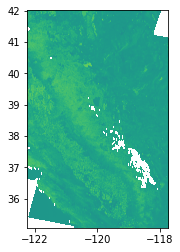

<AxesSubplot: >

In [88]:
import rasterio
from rasterio.plot import show
lala = rasterio.open('/maps/fire-regen/data/rasters/LANDSAT/2019/out/landsat_2019_stack.tif')
show(lala)

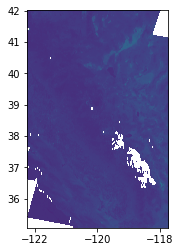

<AxesSubplot: >

In [28]:
import rasterio
from rasterio.plot import show
lala = rasterio.open('/maps/fire-regen/data/rasters/LANDSAT/2018/lala.tif')
show(lala)

In [35]:
import rioxarray as riox
stack = riox.open_rasterio('/maps/fire-regen/data/rasters/LANDSAT/2018/lala.tif')

In [39]:
stack.x.data

array([-122.24772951, -122.24746002, -122.24719052, ..., -117.73585117,
       -117.73558167, -117.73531218])

In [40]:
import pandas as pd
gedi_test = pd.read_csv('/maps/fire-regen/data/sierras_matched_0.csv', index_col=0)

In [42]:
gedi_test.lon_lowestmode.values

array([-117.9833095 , -117.98572486, -117.9852388 , ..., -119.52637281,
       -119.52529731, -119.52728513])

In [58]:
from src.data import raster
importlib.reload(raster)

<module 'src.data.raster' from '/home/jk871/fire-regen/src/data/raster.py'>

In [59]:
stack_raster = raster.RasterSampler('/maps/fire-regen/data/rasters/LANDSAT/2018/out/landsat_2018_stack.tif', raster.LANDSAT_BANDS)

In [60]:
stack_raster.sample(gedi_test, 'lon_lowestmode', 'lat_lowestmode')

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,...,gedi_year,time_since_burn,nbr,ndvi,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7
0,184890800200086632,2022-03-19 02:41:53.252278+00:00,-117.983310,37.034945,19.594500,2.419877,53.254089,2.981980,full,0.959151,...,2022,2022,0.041219,0.151416,10198.500000,11239.500000,11956.833008,16223.833008,17212.166016,14939.333008
1,184891100200081451,2022-03-19 02:41:53.339050+00:00,-117.985725,37.040705,17.788033,1.812951,50.249866,2.982302,full,0.966117,...,2022,2022,0.038890,0.144375,10137.166992,11044.833008,11742.666992,15705.500000,16908.166016,14529.666992
2,184891100200081452,2022-03-19 02:41:53.347314+00:00,-117.985239,37.041043,16.219337,1.336309,47.591499,2.982735,full,0.966954,...,2022,2022,0.026220,0.140641,10313.000000,11360.500000,12131.500000,16102.333008,17417.666016,15279.500000
3,184891100200081453,2022-03-19 02:41:53.355578+00:00,-117.984755,37.041380,6.750648,-9999.000000,29.955231,2.990220,full,0.970945,...,2022,2022,0.014050,0.128124,10732.333008,11915.666992,12820.500000,16588.500000,18243.166016,16128.833008
4,184891100200081454,2022-03-19 02:41:53.363842+00:00,-117.984267,37.041720,4.370386,-9999.000000,24.677294,2.994677,full,0.961078,...,2022,2022,0.001735,0.120176,10834.833008,12156.000000,13223.833008,16836.333984,19121.000000,16778.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504293,47331100200080155,2019-10-13 19:13:12.577412+01:00,-119.687232,40.507830,1.748223,-9999.000000,17.668413,3.003217,full,0.963741,...,2019,2019,0.055358,0.028898,13380.000000,16194.571289,17210.572266,18234.857422,18013.427734,16321.857422
1504310,119971100300277285,2021-01-24 07:10:30.288063+00:00,-119.526911,40.617184,0.882875,-9999.000000,14.616983,3.008275,full,0.954463,...,2021,2021,0.031153,0.041036,13407.625000,16232.500000,17553.000000,19055.250000,19815.500000,17903.875000
1504311,119971100300277286,2021-01-24 07:10:30.296327+00:00,-119.526373,40.616875,0.919862,-9999.000000,14.765323,3.008004,full,0.955713,...,2021,2021,0.033536,0.038924,13254.625000,16014.750000,17283.875000,18683.875000,19260.500000,17471.375000
1504312,119971100300277288,2021-01-24 07:10:30.312855+00:00,-119.525297,40.616258,1.022177,-9999.000000,15.164469,3.007290,full,0.965168,...,2021,2021,0.009344,0.034192,13419.875000,16148.375000,17426.250000,18660.125000,19547.500000,18314.625000


In [51]:
raster.get_idx(stack.x.data, gedi_test.lon_lowestmode.values)

array([15824, 15815, 15817, ..., 10098, 10102, 10095])

In [43]:

raster.get_idxs_two_nearest(stack.x.data, gedi_test.lon_lowestmode.values)

array([[15823, 15824],
       [15814, 15815],
       [15816, 15817],
       ...,
       [10098, 10097],
       [10101, 10102],
       [10094, 10095]])

In [46]:
transformer = rasterio.transform.AffineTransformer(lala.transform)

In [47]:
geo_coords = [(x, y) for x in gedi_test.lon_lowestmode.values for y in gedi_test.lat_lowestmode.values]

KeyboardInterrupt: 

In [49]:
transformer.rowcol(gedi_test.lon_lowestmode.values[1], gedi_test.lat_lowestmode.values[1])

(18465, 15815)

In [45]:
lala.transform_geo_to_xy_coords([(x, y) for x in gedi_test.lon_lowestmode.values for y in gedi_test.lat_lowestmode.values])

AttributeError: 'DatasetReader' object has no attribute 'transform_geo_to_xy_coords'

In [44]:
lala.sample([(x, y) for x in gedi_test.lon_lowestmode.values for y in gedi_test.lat_lowestmode.values])

KeyboardInterrupt: 